### 🎬 Installation

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs

## 🔗 Automatic Installation

In [ ]:
from johnsnowlabs import *

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install(refresh_install=True, visual=True)

## Check Numpy and Skimage version

### Please restart the kernel before doing the following installs.

In [ ]:
! pip install --upgrade numpy==1.21.6

In [2]:
import numpy
numpy.__version__

'1.21.6'

In [ ]:
! pip install --upgrade scikit-image==0.19.3

In [4]:
import skimage
skimage.__version__

'0.19.3'

## 📌 Importing libraries and Starting Session

In [ ]:
import pkg_resources

from pyspark.ml import PipelineModel
from pyspark.sql import functions as F
from sparkocr.transformers import *

In [ ]:
from johnsnowlabs import nlp, visual, finance
import pandas as pd

# Automatically load license data and start a session with all jars user has access to
spark = nlp.start(visual=True)

## ⏳ Load sample pdf file



In [ ]:
!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/03e9b91596f4acc0e56bfd9a017f554e9949a9f8/finance-nlp/data/invoice_01.pdf


    Image #0:
    Origin: file:/content/invoice_01.pdf
    Resolution: 300 dpi
    Width: 2480 px
    Height: 3507 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


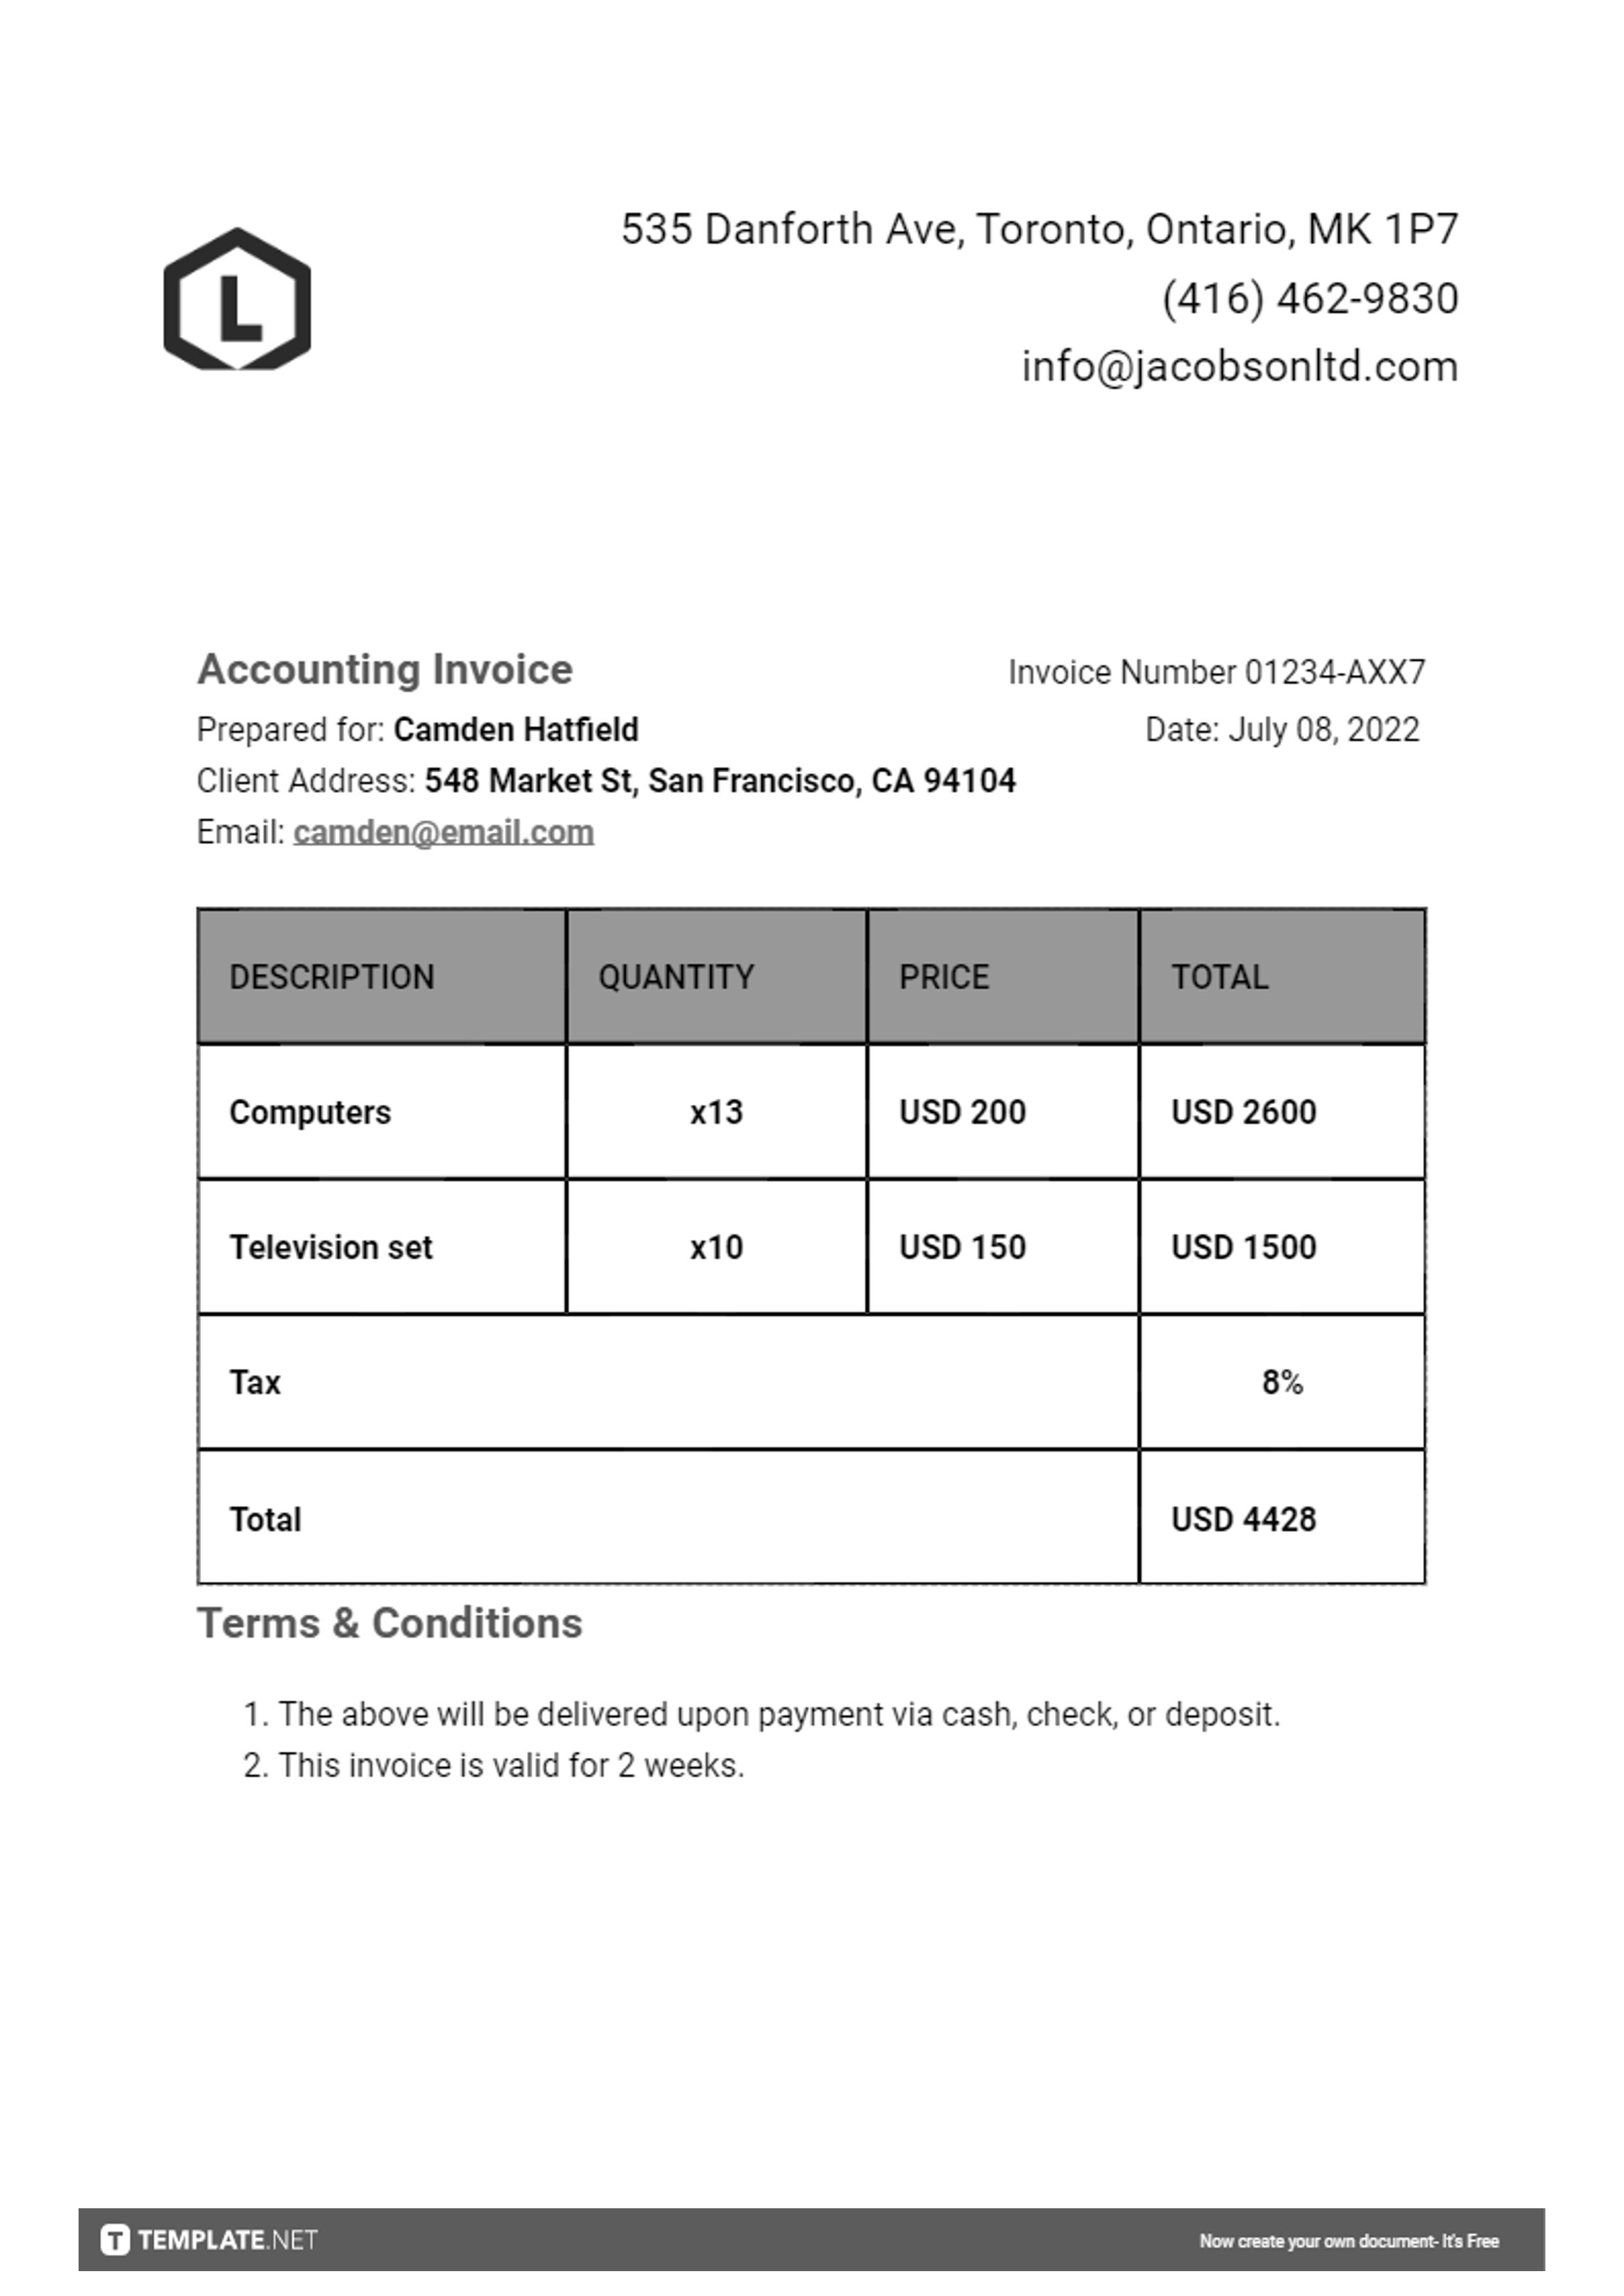


    Image #1:
    Origin: file:/content/invoice_01.pdf
    Resolution: 300 dpi
    Width: 2480 px
    Height: 3507 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


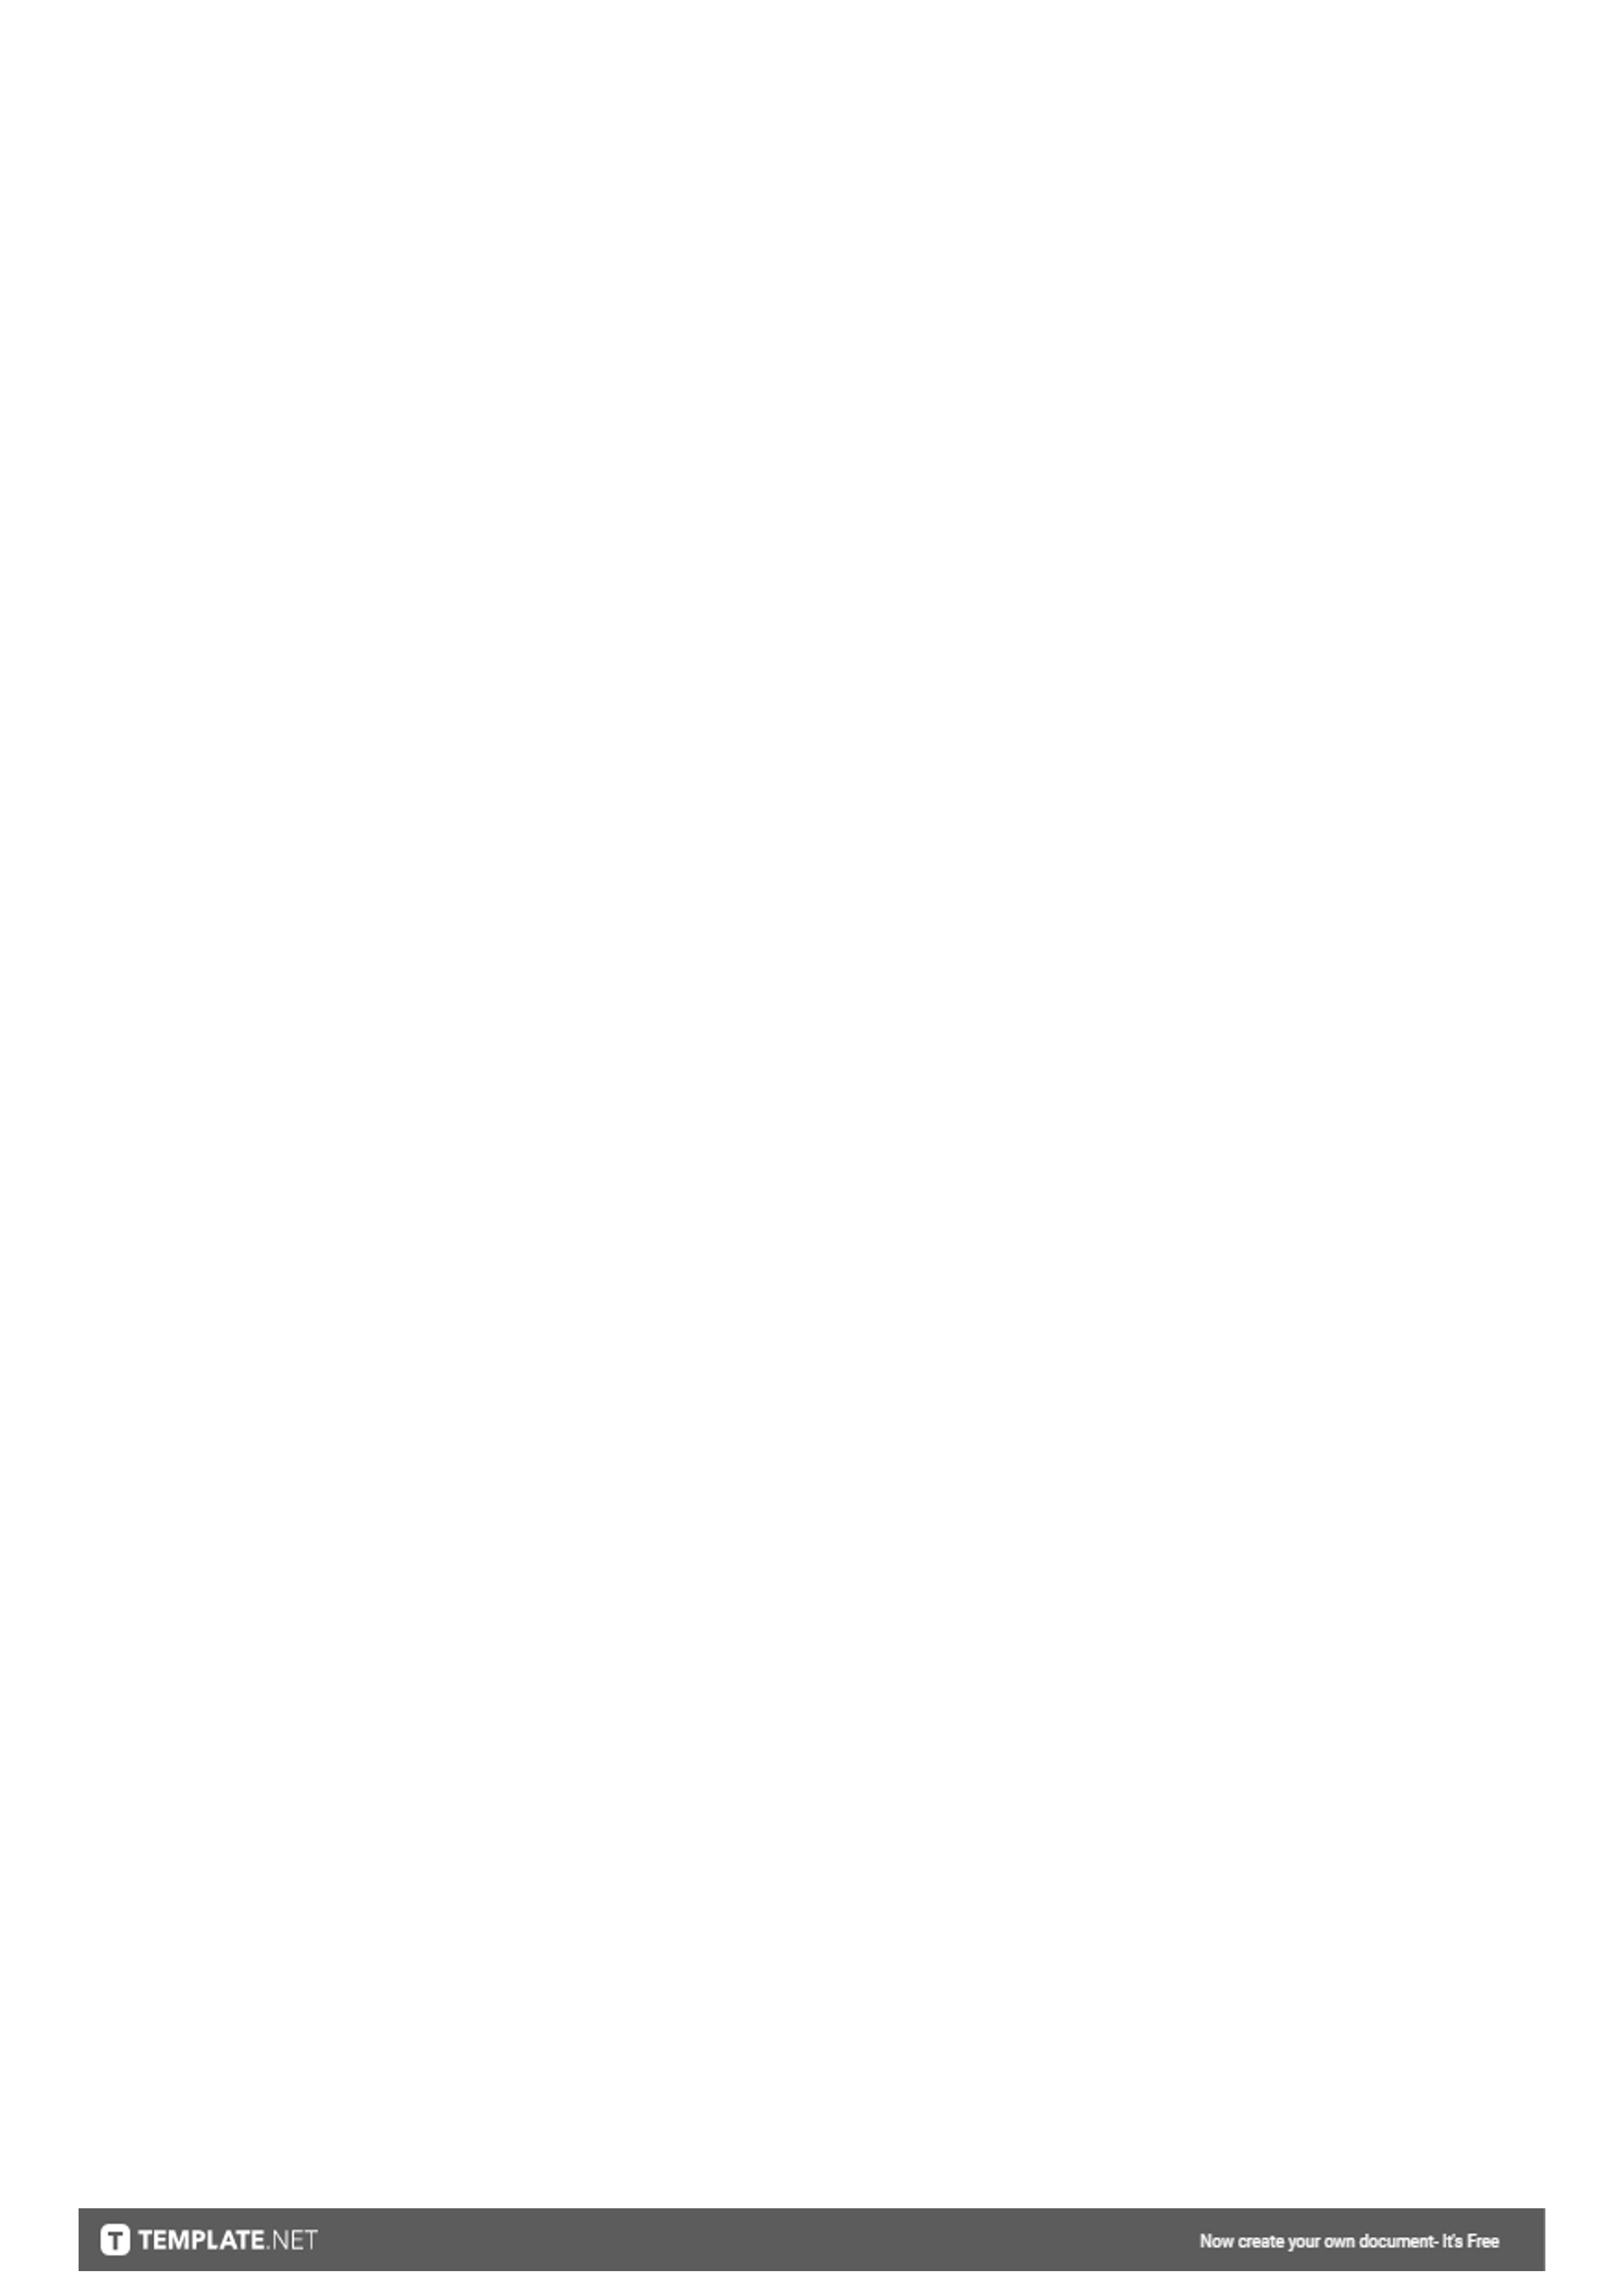

In [8]:
pdf_path = '/content/invoice_01.pdf'

pdf_example_df = spark.read.format("binaryFile").load(pdf_path).cache()

visual.display_pdf(pdf_example_df)

# 📚**Table data extraction**

The `general_model_table_detection_v2` is a pre-trained deep learning model in the Spark NLP library that can be used for table detection in document images. The model is based on a convolutional neural network (CNN) architecture and is designed to detect tables in images of different sizes and aspect ratios.

The function `general_model_table_detection_v2()` in Spark NLP can be used to load the pre-trained model and apply it to an input image to detect tables. The function takes in the following parameters:

- `input_col`: the name of the input column containing the image data
- `output_col`: the name of the output column where the detected table coordinates will be stored
- `threshold`: the confidence threshold for table detection, which ranges from 0 to 1. Only tables with a confidence score above this threshold will be detected.


To get table from PDF file, we use SparkNLP OCR components

In [ ]:
binary_to_image = visual.BinaryToImage()
binary_to_image.setOutputCol("image")
binary_to_image.setImageType(visual.ImageType.TYPE_3BYTE_BGR)

# Detect tables on the page using pretrained model
# It can be finetuned for have more accurate results for more specific documents
table_detector = visual.ImageTableDetector.pretrained("general_model_table_detection_v2", "en", "clinical/ocr")
table_detector.setInputCol("image")
table_detector.setOutputCol("region")

# Draw detected region's with table to the page
draw_regions = visual.ImageDrawRegions()
draw_regions.setInputCol("image")
draw_regions.setInputRegionsCol("region")
draw_regions.setOutputCol("image_with_regions")
draw_regions.setRectColor(visual.Color.red)

# Extract table regions to separate images
splitter = visual.ImageSplitRegions()
splitter.setInputCol("image")
splitter.setInputRegionsCol("region")
splitter.setOutputCol("table_image")
splitter.setDropCols("image")

# Detect cells on the table image
cell_detector = visual.ImageTableCellDetector()
cell_detector.setInputCol("table_image")
cell_detector.setOutputCol("cells")
cell_detector.setAlgoType("morphops")
cell_detector.setDrawDetectedLines(True)

# Extract text from the detected cells 
table_recognition = visual.ImageCellsToTextTable()
table_recognition.setInputCol("table_image")
table_recognition.setCellsCol('cells')
table_recognition.setMargin(1)
table_recognition.setStrip(True)
table_recognition.setOutputCol('table')

# Erase detected table regions
fill_regions = visual.ImageDrawRegions()
fill_regions.setInputCol("image")
fill_regions.setInputRegionsCol("region")
fill_regions.setOutputCol("image_1")
fill_regions.setRectColor(visual.Color.white)
fill_regions.setFilledRect(True)

# OCR
ocr = visual.ImageToText()
ocr.setInputCol("image_1")
ocr.setOutputCol("text")
ocr.setOcrParams(["preserve_interword_spaces=1", ])
ocr.setKeepLayout(True)
ocr.setOutputSpaceCharacterWidth(10)

## Processing of PDF


In [9]:
pdf_to_image = visual.PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setImageType(visual.ImageType.TYPE_3BYTE_BGR) \
    .setKeepInput(True)

pipeline_table_pdf = PipelineModel(stages=[
    pdf_to_image,
    table_detector,
    draw_regions,
    fill_regions,
    splitter,
    cell_detector,
    table_recognition,
    ocr
])

tables_results_pdf = pipeline_table_pdf.transform(pdf_example_df).cache()


    Image #0:
    Origin: file:/content/Copy of Invoice Example Template (7).pdf
    Resolution: 0 dpi
    Width: 2480 px
    Height: 3507 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


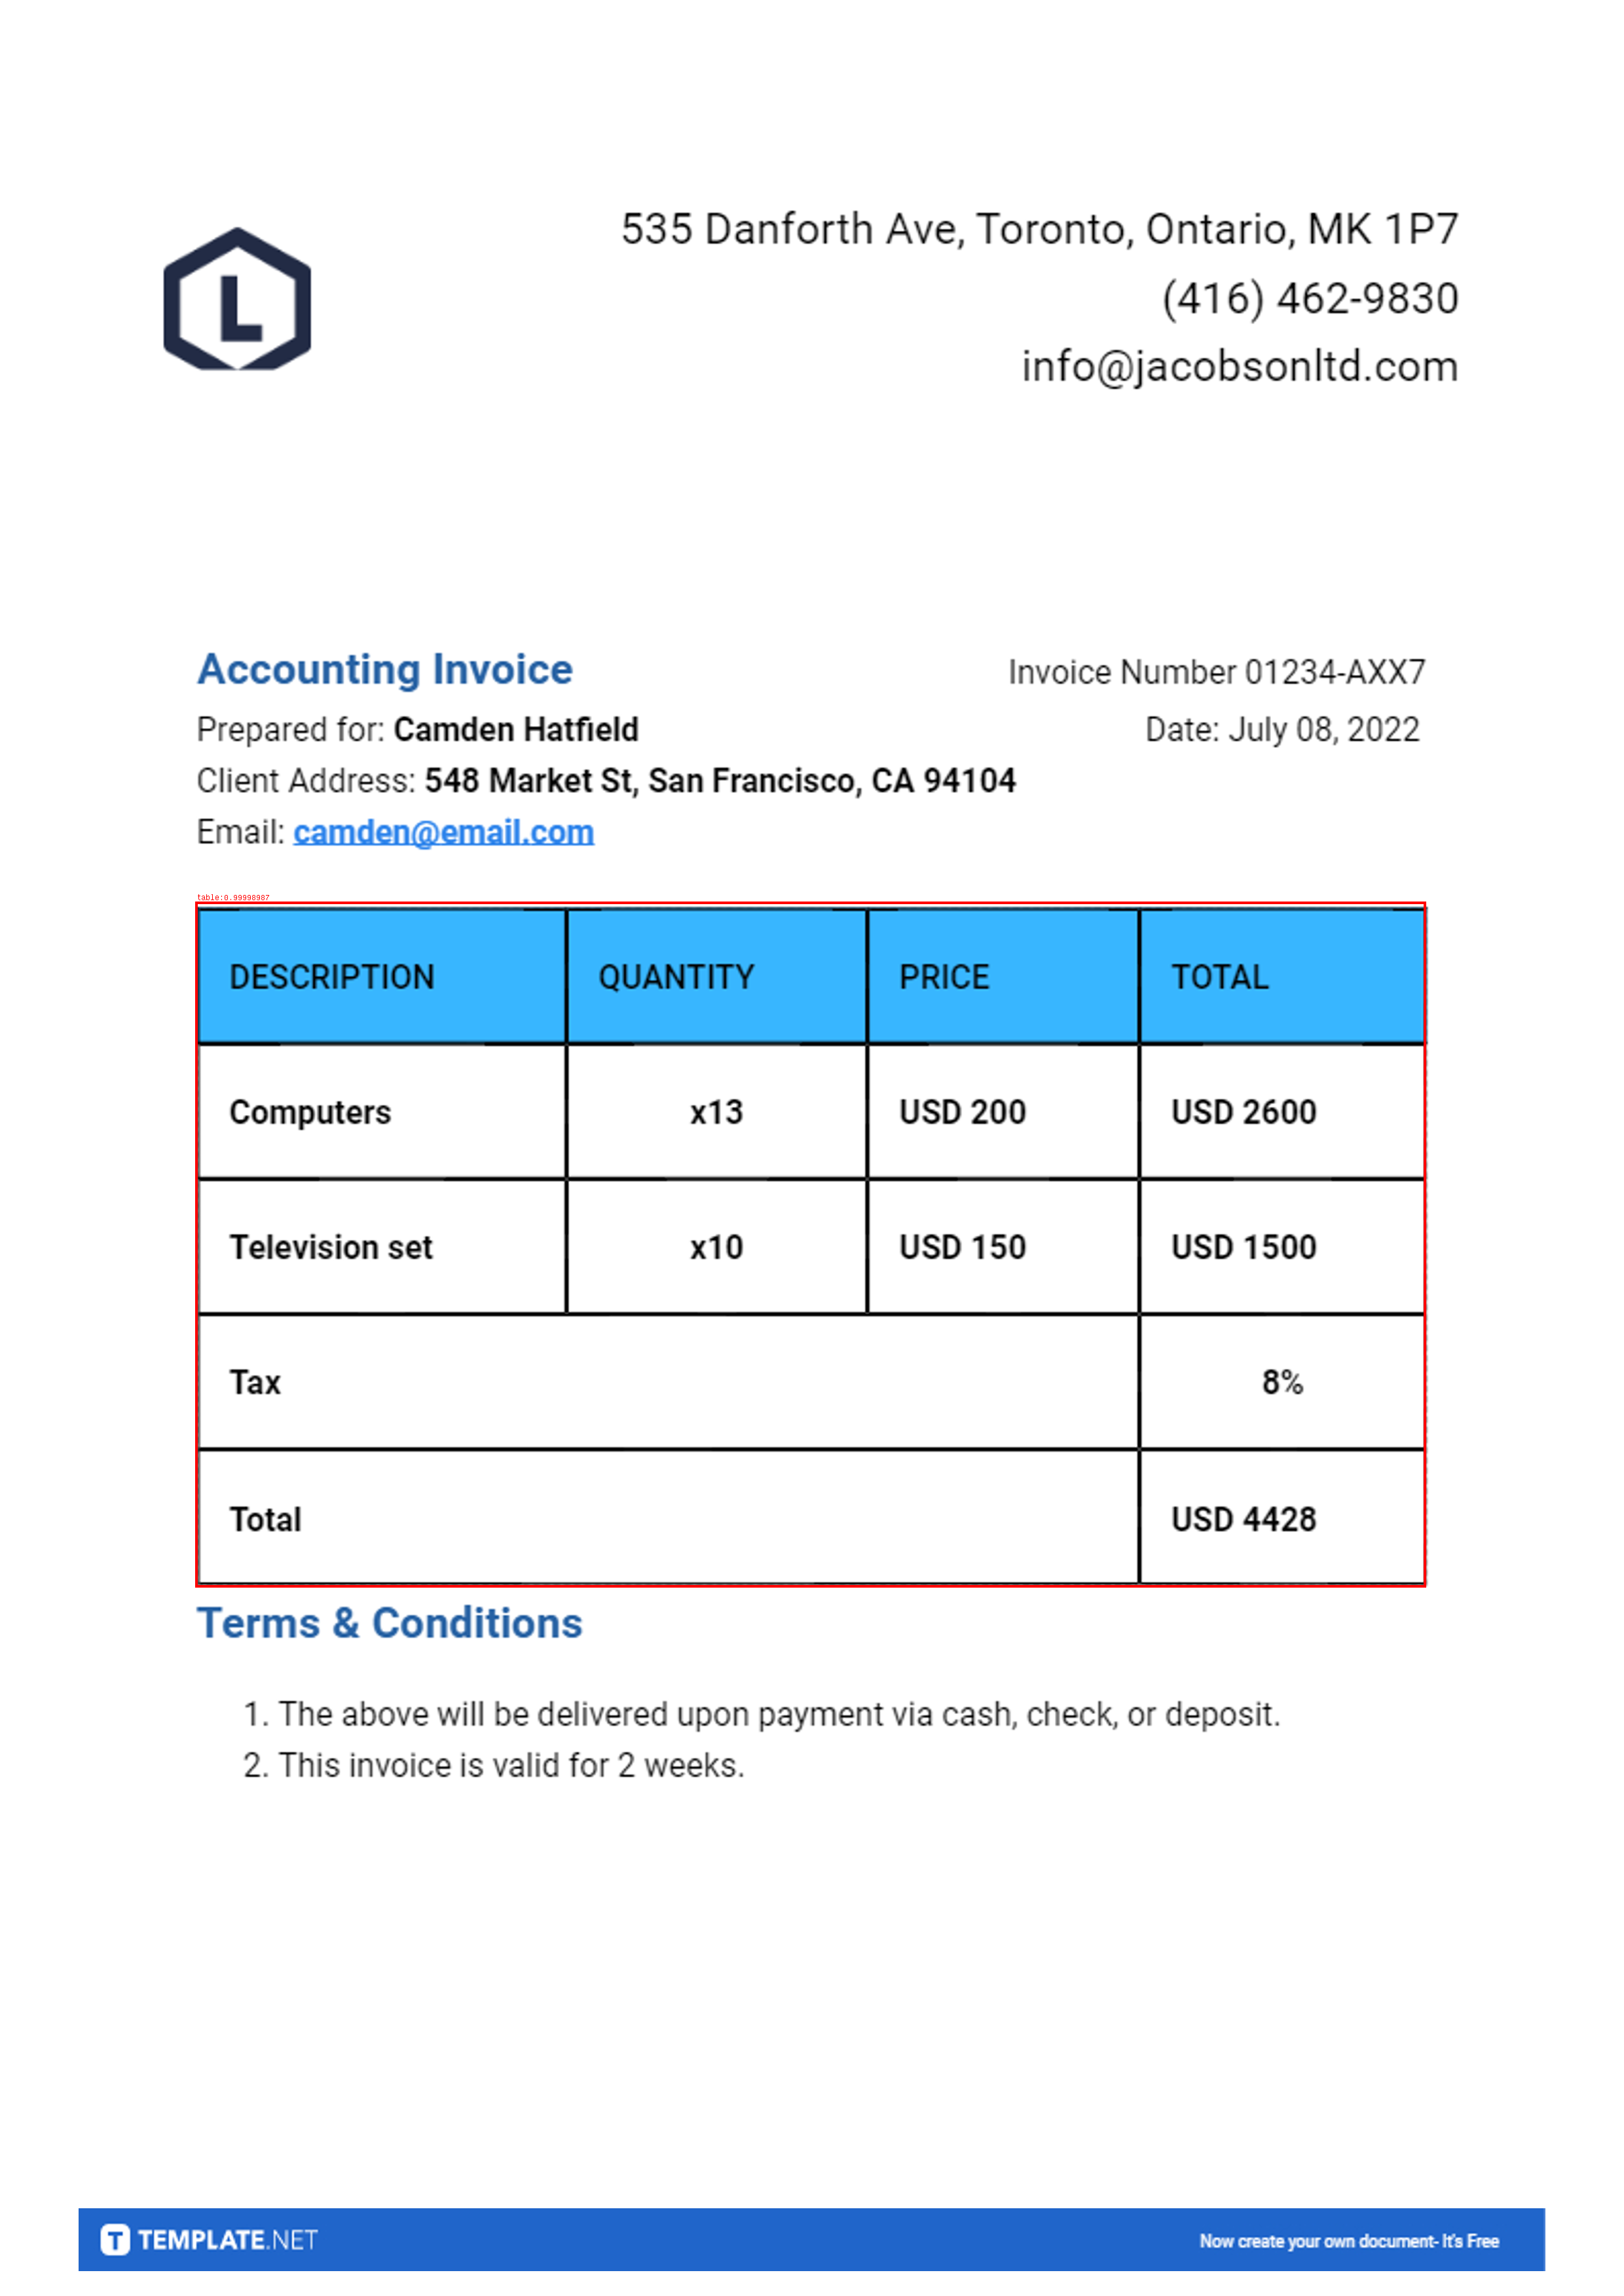

CPU times: user 1.12 s, sys: 294 ms, total: 1.41 s
Wall time: 1min 40s


In [10]:
%%time
visual.display_images(tables_results_pdf, "image_with_regions", limit=1)

Table extracted from pdf

In [31]:
pd.set_option('max_colwidth', 500)
visual.display_tables(tables_results_pdf)

Filename: Copy of Invoice Example Template (7).pdf
Page:     0
Table:    0
4


,col0,col1,col2,col3
0,DESCRIPTION,QUANTITY,PRICE,TOTAL
1,Computers,x13,USD 200,USD 2600
2,Television set,x10,USD 150,USD 1500
3,Tax,,,8%
4,Total,,,USD 4428


In [43]:
tables_results_pdf.select(tables_results_pdf["table.chunks"].getItem(0)["chunkText"]).show(1, False)

+-----------------------------------------+
|table.chunks AS chunks#13571[0].chunkText|
+-----------------------------------------+
|[DESCRIPTION,  QUANTITY,  PRICE,  TOTAL] |
+-----------------------------------------+
only showing top 1 row



## Convert to table and dataframe

In [45]:
import numpy as np

In [44]:
res = tables_results_pdf.toPandas()

In [77]:
arr = res['table'].values[0]

In [78]:
chunk_texts = []

for row in arr.chunks:
    chunk_texts.append([chunk.chunkText.strip() for chunk in row])

# Create DataFrame
df = pd.DataFrame(chunk_texts[1:], columns=chunk_texts[0])
print(df)


      DESCRIPTION QUANTITY    PRICE     TOTAL
0       Computers      x13  USD 200  USD 2600
1  Television set      x10  USD 150  USD 1500
2             Tax                          8%
3           Total                    USD 4428


In [95]:
df

,DESCRIPTION,QUANTITY,PRICE,TOTAL
0,Computers,x13,USD 200,USD 2600
1,Television set,x10,USD 150,USD 1500
2,Tax,,,8%
3,Total,,,USD 4428


In [96]:
df.to_csv("table.csv", index=False)

In [117]:
import csv

filename = 'table.csv'

with open(filename, 'r') as f:
    csv = f.read()

print(csv)

DESCRIPTION,QUANTITY,PRICE,TOTAL
Computers,x13,USD 200,USD 2600
Television set,x10,USD 150,USD 1500
Tax,,,8%
Total,,,USD 4428



# 📚**TapasForQuestionAnswering**

📜 Explanation:

- TapasForQuestionAnswering is based on the transformer architecture, which is a type of neural network that has proven to be highly effective in a wide range of NLP tasks. The model is pre-trained on a large corpus of text data and then fine-tuned on a specific task, such as answering questions based on tables.

- The key innovation of TapasForQuestionAnswering is its ability to parse and interpret information in tables in a way that is similar to how humans read and understand tables. The model is able to identify relevant cells and columns in a table and use this information to answer questions accurately.

- The TapasForQuestionAnswering model has achieved state-of-the-art results on several benchmark datasets, demonstrating its effectiveness at answering questions that require information from tabular data. It has numerous practical applications, including in fields such as finance, healthcare, and scientific research, where large amounts of data are often stored in tables.

## Let's create an example table and some questions using information in the table

In [129]:
queries = [
    "What is the total number of this invoice?",
    "How quantity computers were sold on this invoice?", 
    "How much does a Television set price?",
]

In [130]:
data = spark.createDataFrame([
        [csv, " ".join(queries)]
    ]).toDF("table_json", "questions")

In [ ]:
from johnsnowlabs import nlp, visual, finance

document_assembler = nlp.MultiDocumentAssembler() \
    .setInputCols("table_json", "questions") \
    .setOutputCols("document_table", "document_questions")

text_splitter = finance.TextSplitter() \
    .setInputCols(["document_questions"]) \
    .setOutputCol("questions")

table_assembler = nlp.TableAssembler()\
    .setInputFormat("csv") \
    .setInputCols(["document_table"])\
    .setOutputCol("table")

tapas = nlp.TapasForQuestionAnswering.pretrained("table_qa_tapas_base_finetuned_sqa", "en")\
    .setInputCols(["questions", "table"])\
    .setOutputCol("answers")

pipeline = nlp.Pipeline(stages=[
    document_assembler,
    text_splitter,
    table_assembler,
    tapas
])

In [133]:
model = pipeline.fit(data)
result = model.transform(data)

result.select(F.explode(F.arrays_zip(result.questions.result, result.answers.result)).alias("cols"))\
      .select(F.expr("cols['0']").alias("question"), 
              F.expr("cols['1']").alias("answer")).show(truncate=False)

+-------------------------------------------------+--------+
|question                                         |answer  |
+-------------------------------------------------+--------+
|What is the total number of this invoice?        |USD 4428|
|How quantity computers were sold on this invoice?|x13     |
|How much does a Television set price?            |USD 150 |
+-------------------------------------------------+--------+



# 📚 **Visual Question Answering**

- Visual Question Answering is a task that involves answering natural language questions based on an image. The goal is to develop an AI system that can understand both the visual content of an image and the textual content of a question, and generate an accurate answer.

In [ ]:
!wget https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/finance-nlp/data/invoice_01.png?raw=true

In [13]:
bin_df = spark.read.format("binaryFile").load("/content/invoice_01.png?raw=true")
bin_df.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/content/inv...|2023-05-11 19:05:...| 67866|[89 50 4E 47 0D 0...|
+--------------------+--------------------+------+--------------------+




    Image #0:
    Origin: file:/content/invoice_01.png?raw=true
    Resolution: 95 dpi
    Width: 563 px
    Height: 707 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


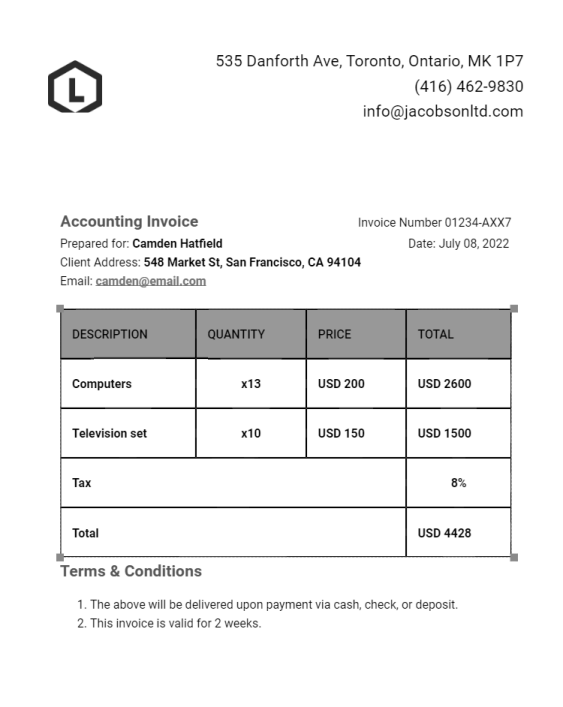

In [14]:
image_df = visual.BinaryToImage().transform(bin_df)
visual.display_images(image_df)

In [15]:
questions = [["Who is this invoice prepared for?",
              "What is the total price paid for the computers?",
              "What is the invoice Number?",
              "What is the client adress?"]]

questions_df = spark.createDataFrame([questions])
questions_df = questions_df.withColumnRenamed("_1", "questions")

In [16]:
image_and_questions = bin_df.join(questions_df)
image_and_questions

path,modificationTime,length,content,questions
file:/content/inv...,2023-05-11 19:05:...,67866,[89 50 4E 47 0D 0...,[Who is this invo...


## Define pipeline

In [17]:
binary_to_image = visual.BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(visual.ImageType.TYPE_3BYTE_BGR)

visual_question_answering = visual.VisualQuestionAnswering()\
    .pretrained("docvqa_donut_base_opt", "en", "clinical/ocr")\
    .setInputCol(["image"])\
    .setOutputCol("answers")\
    .setQuestionsCol("questions")

# OCR pipeline
pipeline = nlp.PipelineModel(stages=[
    binary_to_image,
    visual_question_answering
])

In [18]:
%%time
from pyspark.sql.functions import explode
results = pipeline.transform(image_and_questions).cache()
results.select(results.answers).show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|answers                                                                                                                                                                                                                                    |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[ Who is this invoice prepared for? ->  camden hatfield,  What is the total price paid for the computers? ->  usd 200,  What is the invoice Number? ->  01234-axx7,  What is the client adress? ->  548 market st, san francisco, ca 94104]|
+-----------------------------------------------